In [1]:
import time
import numpy as np
from random import random as rand
from math import floor
from numba import cuda
import matplotlib.pyplot as plt

from osnps.base import KnapsackProblem
from osnps.concrete import SerialOSNPS, ParallelOSNPS

In [15]:
def normalize(arr):
    max_val = float(np.max(arr))
    return [i / max_val for i in arr]

# OSNPS Experiments

## 1. Runtime vs Generations

In [9]:
runs = [
    250,
    500,
    750,
    1000,
    1250,
    1500
]

H = 64
m = 1024

threads_per_block = (16,64)
blocks_per_grid = (16,16)

reps = 7

In [4]:
kp = KnapsackProblem(m)
ffxn = kp.fitness()

In [5]:
model_cpu = SerialOSNPS(H, m, fitness=ffxn)

model_gpu = ParallelOSNPS(H, m, fitness=ffxn)
model_gpu.set_GPU_params(threads_per_block, blocks_per_grid)

## CPU

In [10]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[0])

35 s ± 1.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [11]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[1])

1min 13s ± 1.17 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[2])

1min 49s ± 1.99 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[3])

2min 31s ± 1.98 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [14]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[4])

3min 1s ± 1.53 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [15]:
%timeit _, max_fs, runtime_fs = model_cpu.run(runs[5])

4min 9s ± 1min 9s per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU

In [16]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[0])

1.69 s ± 5.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [17]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[1])

3.37 s ± 6.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [18]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[2])

5.07 s ± 24.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [19]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[3])

6.74 s ± 4.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [20]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[4])

8.49 s ± 85.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [21]:
%timeit _, max_fp, runtime_fp = model_gpu.run(runs[5])

10.5 s ± 177 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## 2. Convergence of solutions

In [3]:
runs = 1000

H = 64
m = 1024

threads_per_block = (16,64)
blocks_per_grid = (16,16)

reps = 7

In [5]:
kp = KnapsackProblem(m)
ffxn = kp.fitness()

In [6]:
model_cpu = SerialOSNPS(H, m, fitness=ffxn)

model_gpu = ParallelOSNPS(H, m, fitness=ffxn)
model_gpu.set_GPU_params(threads_per_block, blocks_per_grid)

In [8]:
cpu_runs = []
gpu_runs = []

for i in range(7):
    _, max_fs, _ = model_cpu.run(runs)
    cpu_runs.append(max_fs)
    print("CPU, run {}".format(i))
    
    _, max_fp, _ = model_gpu.run(runs)
    gpu_runs.append(max_fp)
    print("GPU, run {}".format(i))

CPU, run 0
GPU, run 0
CPU, run 1
GPU, run 1
CPU, run 2
GPU, run 2
CPU, run 3
GPU, run 3
CPU, run 4
GPU, run 4
CPU, run 5
GPU, run 5
CPU, run 6
GPU, run 6


In [16]:
for i in range(reps):
    cpu_runs[i] = normalize(cpu_runs[i])
    gpu_runs[i] = normalize(gpu_runs[i])

In [18]:
cpu_fitnessruns = np.array(cpu_runs)
gpu_fitnessruns = np.array(gpu_runs)

np.save('cpu_fitnessruns', cpu_fitnessruns)
np.save('gpu_fitnessruns', gpu_fitnessruns)

In [24]:
def reject_outliers(data, m = 2.):
    d = np.abs(data - np.median(data))
    mdev = np.median(d)
    s = d/mdev if mdev else 0.
    return data[s<m]

In [42]:
reject_outliers(np.mean(cpu_fitnessruns, axis=0), m=100).shape

(951,)

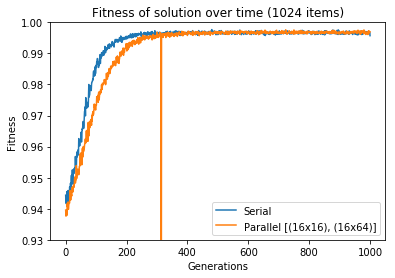

In [45]:
plt.plot(np.arange(runs+1), np.mean(cpu_fitnessruns, axis=0))
plt.plot(np.arange(runs+1), np.mean(gpu_fitnessruns, axis=0))

plt.legend(['Serial', 'Parallel [(16x16), (16x64)]'], loc='lower right')

plt.xlabel('Generations')
plt.ylabel('Fitness')
plt.title('Fitness of solution over time (1024 items)')

ax = plt.gca()
ax.set_ylim([0.93,1.00]) # Skip outlier

plt.show()

## 3. Runtime vs Problem Size

In [49]:
runs = 1000
H = 64
ms = [
    128,
    256,
    512,
    1024,
    2048,
]

threads_per_block = (8,128)
blocks_per_grid = (8,32)

reps = 7

In [50]:
ffxns = [KnapsackProblem(m).fitness() for m in ms]

In [51]:
models_cpu = [SerialOSNPS(H, ms[i], fitness=ffxns[i]) for i in range(len(ms))]
models_gpu = [ParallelOSNPS(H, ms[i], fitness=ffxns[i]) for i in range(len(ms))]

for gpu in models_gpu:
    gpu.set_GPU_params(threads_per_block, blocks_per_grid)

### CPU

In [52]:
%timeit _, max_fs, runtime_fs = models_cpu[0].run(runs)

22.3 s ± 229 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [53]:
%timeit _, max_fs, runtime_fs = models_cpu[1].run(runs)

43.9 s ± 256 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [54]:
%timeit _, max_fs, runtime_fs = models_cpu[2].run(runs)

1min 28s ± 1.06 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [55]:
%timeit _, max_fs, runtime_fs = models_cpu[3].run(runs)

2min 56s ± 1.31 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [56]:
%timeit _, max_fs, runtime_fs = models_cpu[4].run(runs)

5min 53s ± 4.11 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


### GPU

In [57]:
%timeit _, max_fs, runtime_fs = models_gpu[0].run(runs)

2.41 s ± 4.78 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [58]:
%timeit _, max_fs, runtime_fs = models_gpu[1].run(runs)

2.92 s ± 5.48 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [59]:
%timeit _, max_fs, runtime_fs = models_gpu[2].run(runs)

4.55 s ± 18.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [60]:
%timeit _, max_fs, runtime_fs = models_gpu[3].run(runs)

6.79 s ± 19.4 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [61]:
%timeit _, max_fs, runtime_fs = models_gpu[4].run(runs)

12 s ± 35.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## GPU Stress-testing

In [ ]:
runs = 1000
H = 64
m = 4096

threads_per_block = (8,128)
blocks_per_grid = (8,32)

reps = 7